In [55]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from joblib import dump, load
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import nbformat
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

In [98]:
TEMP_LOW_LIMIT = -459.67
TEMP_HIGH_LIMIT = 1000
RPM_LOW_LIMIT = 0
RPM_HIGH_LIMIT = 6e8  # the largest achieved rpm of all human artifacts

def exclude_physical_anml(df):
    result = df[(df['motor_temp'] > TEMP_LOW_LIMIT) & (df['inlet_temp'] > TEMP_LOW_LIMIT) & (df['rpm'] > 0) & (df['rpm'] < RPM_HIGH_LIMIT)]
    return result

def peek_attributes_trend(attribute, ylim_low=-10, ylim_high=1500):
    units = ["000{}".format(num) if num < 10 else "00{}".format(num) for num in random.sample(range(0, 20), 9)]
    file_names = ["../data/raw/train/unit{}_rms.csv".format(unit) for unit in units]
    sns.set()
    f, axs = plt.subplots(3, 3, figsize=(20, 12))
    for idx, file_name in enumerate(file_names):
        file_df = pd.read_csv(file_name)
        file_df = exclude_physical_anml(file_df)
        ax1 = plt.subplot(3, 3, idx + 1)
        file_df[attribute].plot(ylim=(ylim_low, ylim_high))
    plt.show()
    
def load_file(unit, file_type='rms', version='raw', folder='train'):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    if version == 'raw':
        file_name = '../data/raw/{}/unit{}_{}.csv'.format(folder, unit_name, file_type)
    else:
        file_name = '../data/processed/{}/unit{}_{}_anomaly_excluded.csv'.format(folder, unit_name, file_type)
    df = pd.read_csv(file_name, index_col=0)
    if file_type == 'rms':
        df = exclude_physical_anml(df)
    return df

def load_all_files():
    units = range(0, 20)
    df_all = pd.DataFrame()
    for idx, unit in enumerate(units):
        file_name = "../data/processed/train/unit{}_rms_anomaly_excluded.csv".format("000{}".format(unit) if unit < 10 else "00{}".format(unit))
        file_df = pd.read_csv(file_name, index_col=0)
        file_df['unit'] = unit
        df_all = df_all.append(file_df)
    return df_all

def transform_column(df_input):
    num_features = df_input.columns[1:]
    num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_features)
    ])
    np_pipelined = full_pipeline.fit_transform(df_input)
    df_pipelined = pd.DataFrame(np_pipelined, index=df_input.index)
    return df_pipelined

def count_clustered_labels(labels_, algorithm_name):
    print("clustering result by {}\n{}".format(algorithm_name, Counter(labels_)))

In [42]:
df_all = load_all_files()
df_all

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit
53,2003-12-14 04:45:12.721247385,956.579922,217.484012,25.042943,63.002208,34.350839,0
54,2003-12-14 04:55:40.840586778,1063.856934,206.792646,28.782024,69.830473,28.464714,0
55,2003-12-14 05:05:37.291038943,1005.212018,219.900341,29.302032,68.019838,39.165607,0
56,2003-12-14 05:17:06.465193131,1115.011284,220.373208,30.767473,79.283341,32.983723,0
57,2003-12-14 05:25:31.807130176,1028.243351,194.055713,28.676094,75.055177,37.553089,0
...,...,...,...,...,...,...,...
24341,2005-04-11 18:16:25.989419843,1042.179737,307.539123,47.975455,218.791347,100.807647,19
24342,2005-04-11 18:26:55.689073846,1069.597134,297.454082,47.263750,218.882763,109.359761,19
24343,2005-04-11 18:35:25.402556965,1116.392388,316.277175,50.395914,218.935540,102.472228,19
24344,2005-04-11 18:45:44.900113142,1122.974015,320.776152,49.165122,225.527057,103.086940,19


PCA attempt for dimensionality reduction

[0.64654944 0.16617698 0.1442985  0.02933082 0.0097254  0.00391886]


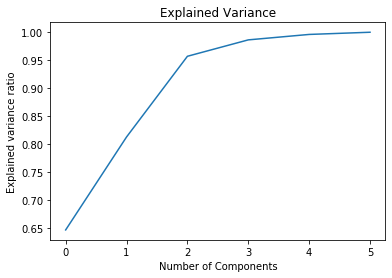

In [74]:
def run_PCA(df_input, n_components=6):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(transform_column(df_input))
    print(pca.explained_variance_ratio_)
    
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel("Number of Components")
    plt.ylabel("Explained variance ratio")
    plt.title("Explained Variance")
    plt.xticks(np.arange(0, n_components, 1))
    plt.show()
    return pca_result

pca_6_all_result = run_PCA(df_all, 6)

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(transform_column(df_all))

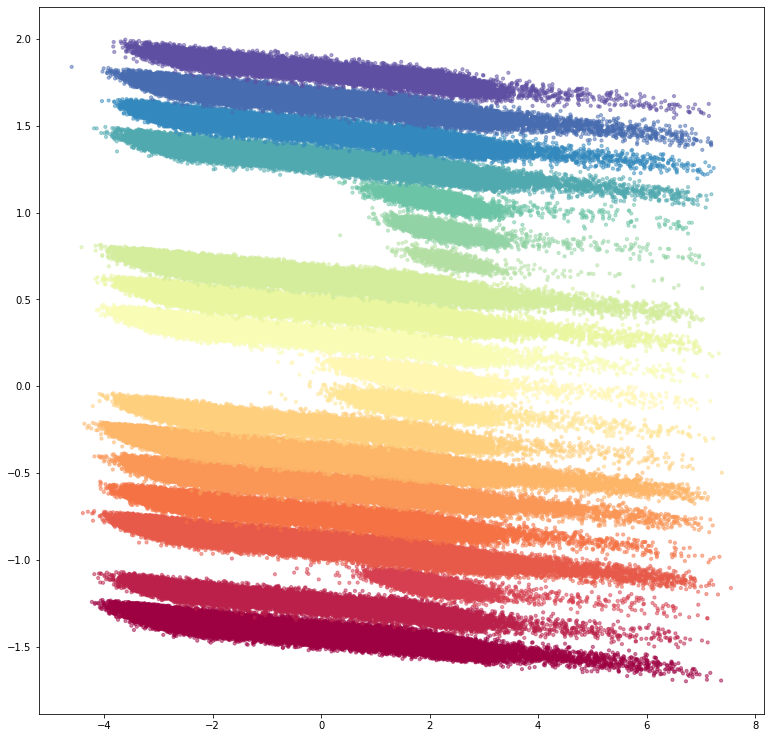

In [42]:
fig, ax = plt.subplots(figsize=(13, 13))
plt.scatter(x=[p[0] for p in pca_result], y=[p[1] for p in pca_result], c=df_all['unit'], cmap='Spectral', marker='o', alpha=0.5, s=10)
plt.show()

Merging all train data and plot on 2D plain using TSNE

In [11]:
tsne_model_all = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=0, random_state=0, angle=0.75)
tsne_vectors_all = tsne_model_all.fit_transform(transform_column(df_all))

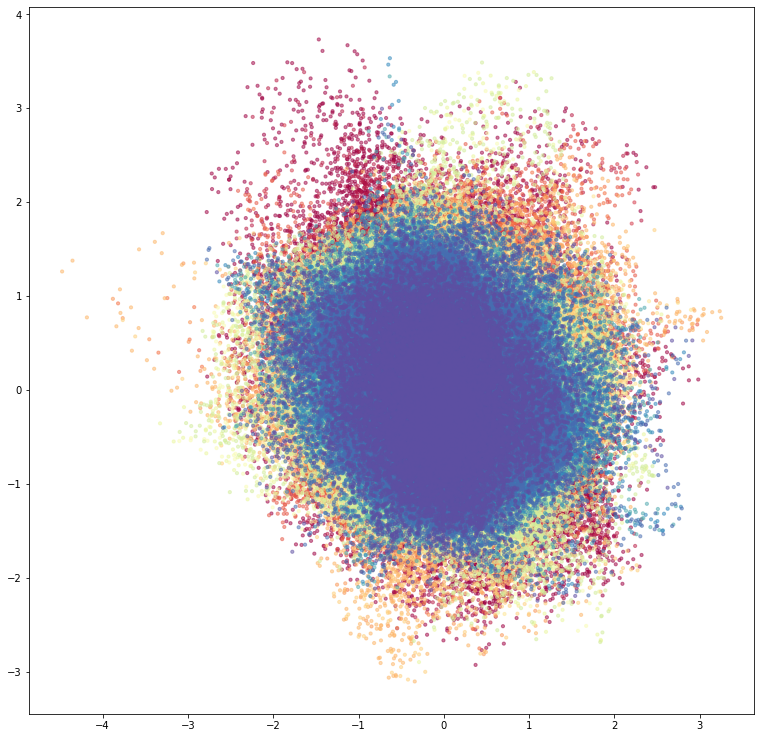

In [12]:
fig, ax = plt.subplots(figsize=(13, 13))
tsne_vectors_all_scaled = tsne_vectors_all * 1e5
plt.scatter(x=tsne_vectors_all_scaled[:, 0], y=tsne_vectors_all_scaled[:, 1], marker='o', c=df_all['unit'], cmap='Spectral', alpha=0.5, s=10)
plt.show()

In [ ]:
dbscan = DBSCAN(eps=15, min_samples=5)
print("model initialized")
dbscan.fit(df_all[df_all.columns[1:]])
print("model trained")
dump(dbscan, '../models/clustering/all_units_dbscan.joblib')
print("model saved")
dbscan.labels_

model initialized


In [20]:
dbscan = load('../models/clustering/all_units_dbscan.joblib')
set(dbscan.labels_)

{-1, 0, 1, 2, 3}

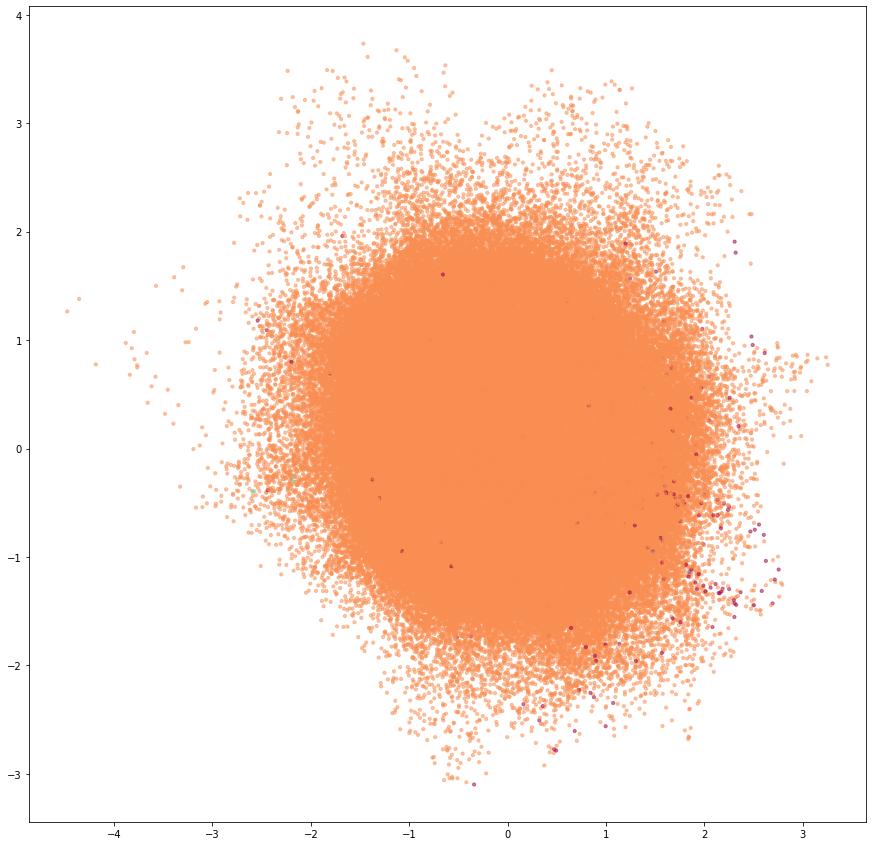

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(x=tsne_vectors_all_scaled[:, 0], y=tsne_vectors_all_scaled[:, 1], c=dbscan.labels_, cmap='Spectral', marker='o', alpha=0.5, s=10)
plt.show()

In [89]:
def plot_clustering(algorithm_name, labels, pca_result, size=5, alpha=0.5, cmap='Spectral'):
    print("clustering result by {}\n{}".format(algorithm_name, Counter(labels)))
    fig, ax = plt.subplots(figsize=(13, 13))
    plt.scatter(x=[p[0] for p in pca_result], y=[p[1] for p in pca_result], c=labels, cmap=cmap, marker='o', alpha=alpha, s=size)
    plt.show()

clustering result by DBSCAN
Counter({0: 836724, -1: 442, 1: 5, 3: 5, 2: 5})


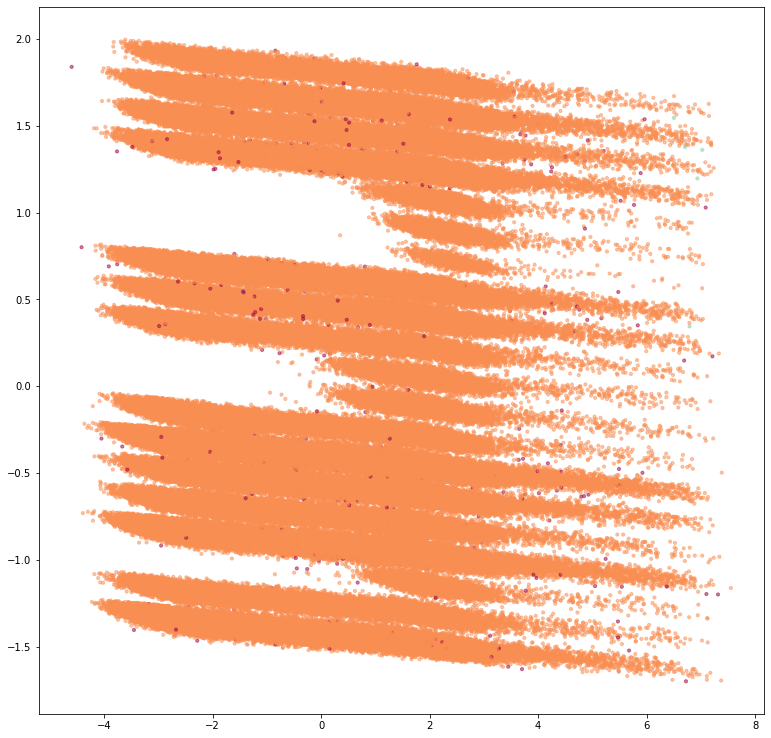

In [30]:
plot_clustering('DBSCAN', dbscan.labels_, pca_result)

K-Means

In [26]:
def train_kmeans(n_clusters=10, init='k-means++', n_init=10, tol=1e-4, precompute_distances='auto', algorithm='auto'):
    df_all_features = df_all.drop(columns=['timestamp'], axis=1)
    kmeans_model = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, tol=tol,
                   precompute_distances=precompute_distances, algorithm=algorithm)
    kmeans_model.fit_predict(df_all_features)
    return kmeans_model

clustering result by KMeans with default parameters
Counter({0: 117560, 9: 110297, 4: 101883, 1: 97691, 2: 89321, 3: 88612, 7: 65850, 8: 59708, 5: 57339, 6: 48920})


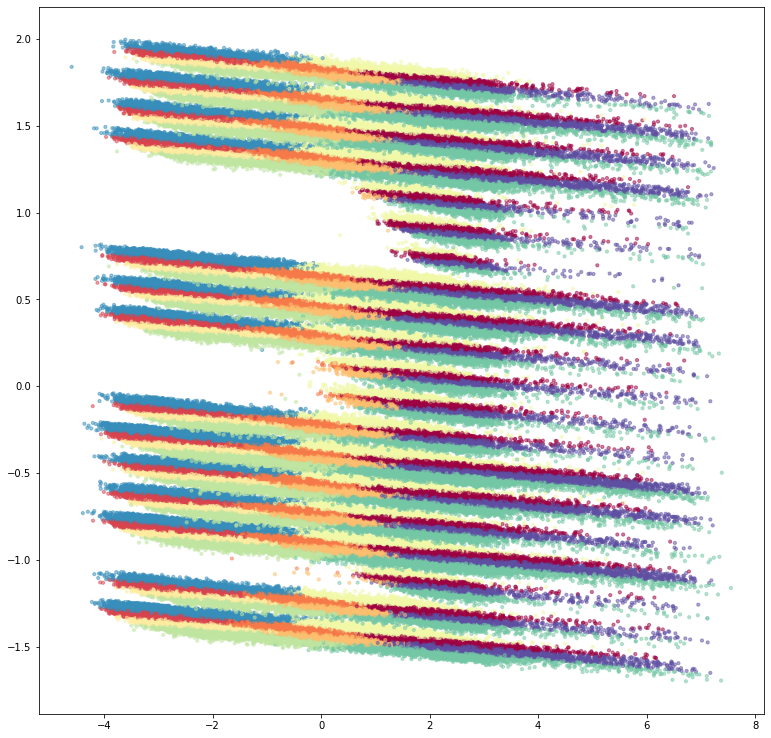

In [32]:
km_10 = train_kmeans(n_clusters=10)
plot_clustering('KMeans with default parameters', km_10.labels_, pca_result)

clustering result by KMeans with 15 clusters
Counter({1: 95221, 11: 79949, 6: 74886, 10: 67542, 5: 65016, 8: 63981, 0: 63315, 12: 59061, 4: 58447, 7: 57062, 9: 38922, 13: 37945, 3: 35555, 14: 31433, 2: 8846})


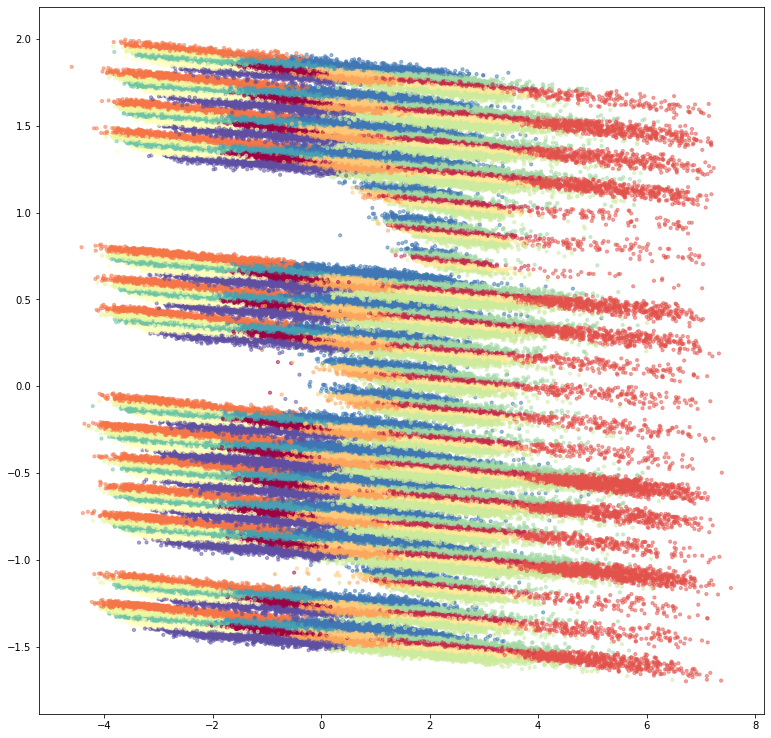

In [33]:
km_15 = train_kmeans(n_clusters=15, n_init=20, precompute_distances=True, algorithm='elkan')
plot_clustering('KMeans with 15 clusters', km_15.labels_, pca_result)

In [64]:
columns = load_file(0).columns.tolist()
stat_attrs = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
for element in itertools.product(columns, stat_attrs):
    print(element)



,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.004300e+04,9.004300e+04,9.004300e+04,9.004300e+04,9.004300e+04
mean,2.419849e+04,-6.180711e+60,1.727206e+50,3.008751e+44,9.478167e+20
std,2.019407e+06,1.854656e+63,5.183294e+52,9.028409e+46,1.784901e+23
min,2.661644e-03,-5.565298e+65,-1.271203e+51,-1.754992e+02,-3.887693e+02
25%,1.020640e+03,2.323050e+02,3.254418e+01,1.188791e+02,6.529238e+01
50%,1.067295e+03,2.676806e+02,3.962538e+01,1.575630e+02,7.821359e+01
75%,1.106958e+03,2.994706e+02,4.607678e+01,1.979714e+02,9.085866e+01
max,3.741722e+08,3.952714e+40,1.555360e+55,2.709170e+49,4.111321e+25


Try clustering on unit level

In [108]:
def aggregate_stats_all_units(folder='train'):
    columns = load_file(0).columns.tolist()
    stat_attrs = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
    df_all_stats_columns = []
    for element in itertools.product(columns, stat_attrs):
        df_all_stats_columns.append("{}-{}".format(element[0], element[1]))
    df_all_stats = pd.DataFrame(columns=df_all_stats_columns)

    units = range(0, 20) if folder == 'train' else range(20, 50)
    for unit in units:
        df_unit = load_file(unit, version='processed', folder=folder).describe()
        row_value_dict = {}
        for column_name in df_all_stats_columns:
            feature, stat_attr = column_name.split('-')
            row_value_dict[column_name] = df_unit.loc[stat_attr][feature]
            df_all_stats.loc[unit] = pd.Series(row_value_dict)
    return df_all_stats
    
df_all_stats_train = aggregate_stats_all_units(folder='train')
df_all_stats_train

,rpm-mean,rpm-std,rpm-min,rpm-25%,rpm-50%,rpm-75%,rpm-max,motor_voltage-mean,motor_voltage-std,motor_voltage-min,...,motor_temp-50%,motor_temp-75%,motor_temp-max,inlet_temp-mean,inlet_temp-std,inlet_temp-min,inlet_temp-25%,inlet_temp-50%,inlet_temp-75%,inlet_temp-max
0,1075.874653,52.292314,893.250856,1040.324911,1076.183323,1111.547320,1235.924901,272.490260,34.167539,133.155140,...,166.693740,200.424148,252.302654,79.461159,15.032462,26.980473,67.762234,80.323512,91.622040,128.792918
1,1074.993313,52.570968,884.728463,1039.972229,1075.120243,1110.868006,1237.475475,270.250421,34.163500,128.957538,...,160.209259,197.229128,246.512993,78.455916,15.295765,24.793982,67.094990,78.789520,90.760189,125.018349
2,1054.689129,49.895352,879.550263,1020.841102,1054.449839,1088.020038,1212.353557,231.064596,11.047710,190.622108,...,115.873572,121.656077,145.656014,63.112986,7.611716,35.333124,58.618158,63.533344,68.104518,85.350713
3,1073.079796,52.300358,884.710745,1037.625454,1073.219965,1108.644553,1234.676771,266.195076,34.260374,131.319809,...,152.220921,192.120039,241.676550,76.968910,15.235181,24.708386,65.435131,76.515975,89.197841,125.743071
4,1076.158399,52.088357,890.684240,1040.899698,1076.395011,1111.732572,1238.340181,272.163574,33.034801,136.932053,...,163.626374,198.762892,249.690569,79.348732,14.686702,27.589569,68.102962,79.911945,91.244182,126.016548
5,1072.630685,52.313874,876.080587,1037.527881,1072.908086,1108.117698,1237.233022,265.859774,33.333720,130.650064,...,153.128196,189.938126,250.278443,76.718204,14.967667,24.145988,65.659784,76.738451,88.580264,124.762573
6,1074.345708,52.122646,892.113424,1039.112504,1074.464773,1109.888856,1233.376777,268.741483,33.704033,134.348509,...,156.657644,195.813094,256.191996,78.089319,14.955724,27.012003,66.779249,77.919604,90.111904,126.397398
7,1079.180878,52.259719,895.080955,1043.893293,1079.549777,1114.376977,1237.354901,277.362480,34.523378,128.679552,...,179.522453,206.474805,267.481856,81.559742,15.077685,27.629660,69.412827,83.662883,93.710401,131.587009
8,1056.818721,49.596302,886.626956,1022.690774,1056.970896,1089.996195,1205.087808,234.986701,13.105453,188.226650,...,118.640125,126.866151,153.537570,64.325583,7.918054,37.307675,59.411813,64.699086,69.701106,87.416620
9,1057.704444,50.319923,875.487674,1023.594054,1057.858544,1092.155544,1207.682871,235.993630,13.290878,185.014652,...,119.827644,128.914013,159.791065,64.756424,8.155188,35.217244,59.676423,65.114791,70.336887,89.537613


clustering result by KMeans on unit level data
Counter({2: 14, 0: 5, 1: 1})


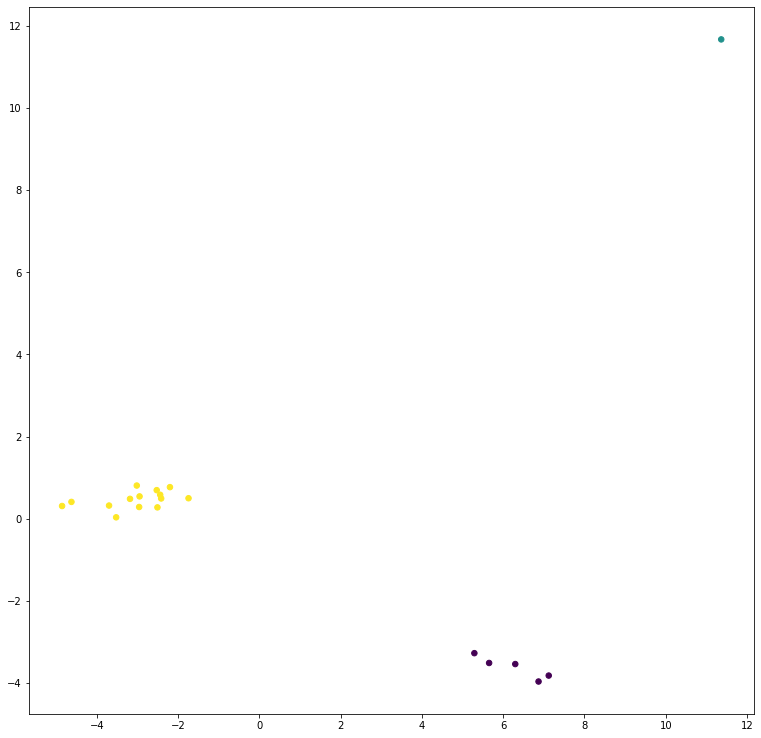

array([2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2],
      dtype=int32)

In [104]:
km_2_train_unit_level = KMeans(n_clusters=3, n_init=20, precompute_distances=True, algorithm='elkan')
km_2_train_unit_level.fit_predict(df_all_stats_train)
plot_clustering('KMeans on unit level data', km_2_train_unit_level.labels_, pca_2_train_result, size=30, alpha=1, cmap='viridis')
km_2_train_unit_level.labels_

cluster 1: 0000, 0001, 0003, 0004, 0005, 0006, 0007, 0010, 0011, 0012, 0016, 0017, 0018, 0019


cluster 2: 0002, 0008, 0009, 0014, 0015

cluster 3: 0013

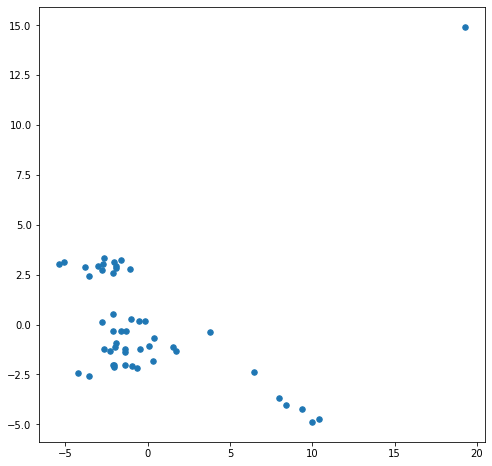

In [111]:
df_all_stats_test = aggregate_stats_all_units(folder='test')
df_all_stats = pd.concat([df_all_stats_train, df_all_stats_test])

pca_2_all = PCA(n_components=2)
pca_2_all_result = pca.fit_transform(transform_column(df_all_stats))
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(x=[p[0] for p in pca_2_all_result], y=[p[1] for p in pca_2_all_result], cmap='Spectral', marker='o', alpha=1, s=30)
plt.show()

clustering result by KMeans on unit level data
Counter({0: 43, 2: 6, 1: 1})


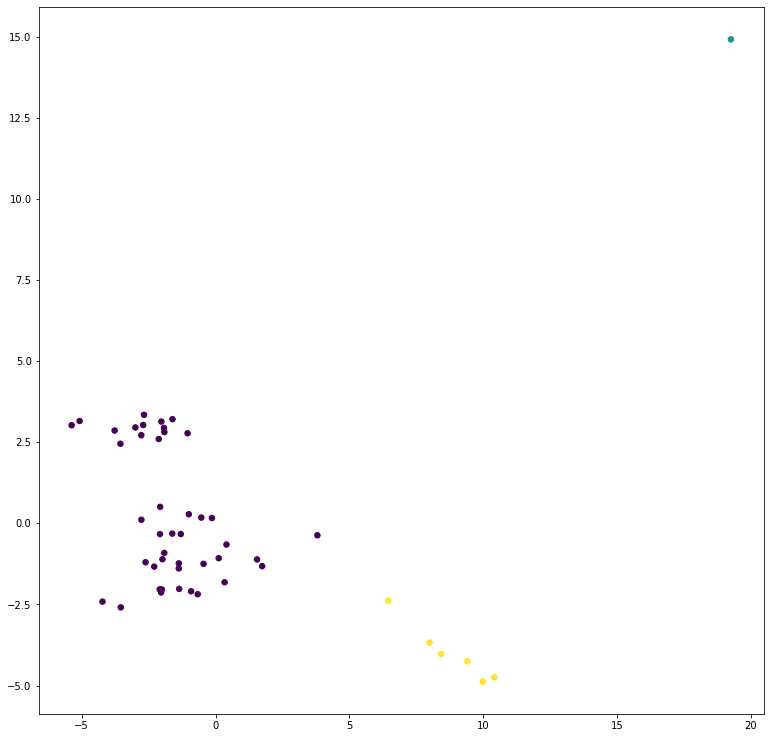

array([0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [112]:
km_2_all_unit_level = KMeans(n_clusters=3, n_init=20, precompute_distances=True, algorithm='elkan')
km_2_all_unit_level.fit_predict(df_all_stats)
plot_clustering('KMeans on unit level data', km_2_all_unit_level.labels_, pca_2_all_result, size=30, alpha=1, cmap='viridis')
km_2_all_unit_level.labels_